## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [2]:
import time
import datetime
from datetime import datetime
from sklearn.metrics import confusion_matrix

In [3]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


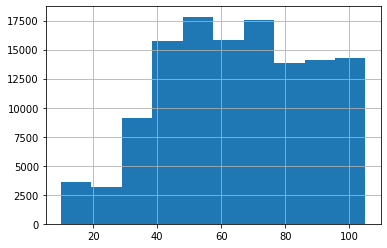

In [7]:
df_transactions['tran_amount'].hist()

In [8]:
# convert string to datetime  -->> Select year between 2013 - 2015
df_transactions['datetime'] = df_transactions.trans_date.values.astype( datetime)
# datime value start at 2013-01-01 ... 1356973200000000000
df_transactions = df_transactions.drop(df_transactions[df_transactions.datetime < 1356973200000000000].index)
print( df_transactions )

       customer_id trans_date  tran_amount             datetime
0           CS5295 2013-02-11           35  1360540800000000000
1           CS4768 2015-03-15           39  1426377600000000000
2           CS2122 2013-02-26           52  1361836800000000000
4           CS1850 2013-11-20           78  1384905600000000000
5           CS5539 2014-03-26           81  1395792000000000000
...            ...        ...          ...                  ...
124991      CS8076 2014-05-16           68  1400198400000000000
124996      CS7232 2014-08-19           38  1408406400000000000
124997      CS8731 2014-11-28           42  1417132800000000000
124998      CS8133 2013-12-14           13  1386979200000000000
124999      CS7996 2014-12-13           36  1418428800000000000

[71801 rows x 4 columns]


## **Data Preparation**

In [9]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,datetime,recent
0,CS5295,2013-02-11,35,1360540800000000000,764.0
1,CS4768,2015-03-15,39,1426377600000000000,2.0
2,CS2122,2013-02-26,52,1361836800000000000,749.0
4,CS1850,2013-11-20,78,1384905600000000000,482.0
5,CS5539,2014-03-26,81,1395792000000000000,356.0


In [10]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [11]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,7,463
1,CS1113,36.0,12,872
2,CS1114,33.0,12,856
3,CS1115,12.0,12,925
4,CS1116,204.0,6,392


In [12]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [13]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,7,463,684,66.142857
1,CS1113,36.0,12,872,705,72.666667
2,CS1114,33.0,12,856,756,71.333333
3,CS1115,12.0,12,925,775,77.083333
4,CS1116,204.0,6,392,598,65.333333


## **Calculating response rate**

In [14]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


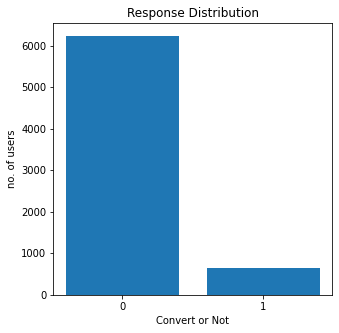

In [15]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [16]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,7,463
1,CS1113,0,36.0,12,872
2,CS1114,1,33.0,12,856
3,CS1115,1,12.0,12,925
4,CS1116,1,204.0,6,392


In [17]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,7,463,684,66.142857
1,CS1113,0,36.0,12,872,705,72.666667
2,CS1114,1,33.0,12,856,756,71.333333
3,CS1115,1,12.0,12,925,775,77.083333
4,CS1116,1,204.0,6,392,598,65.333333


## **Creating train and test dataset**

In [18]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [19]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.7, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.7, random_state=0)

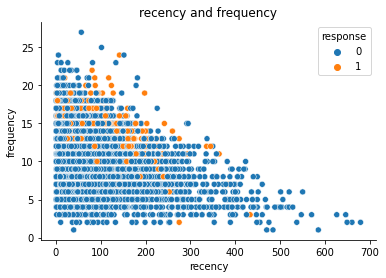

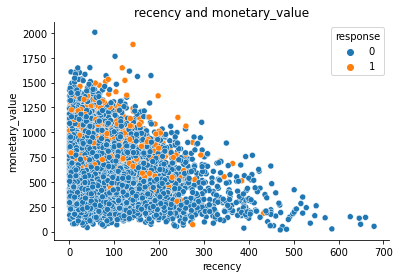

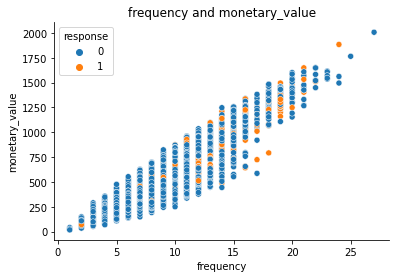

In [20]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

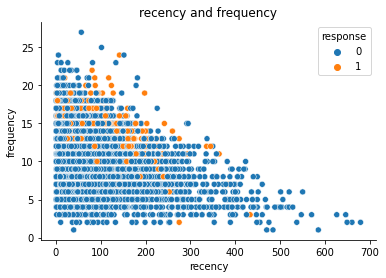

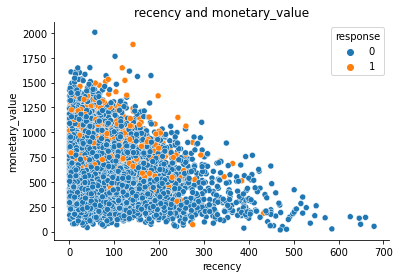

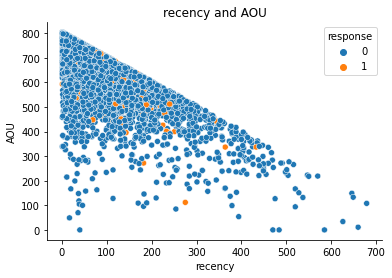

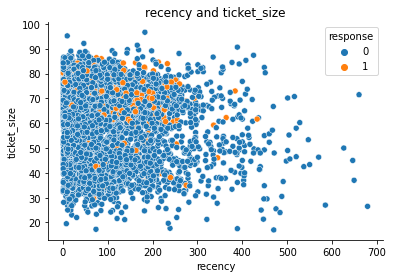

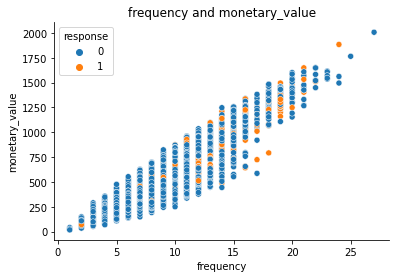

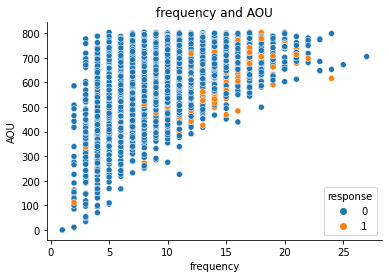

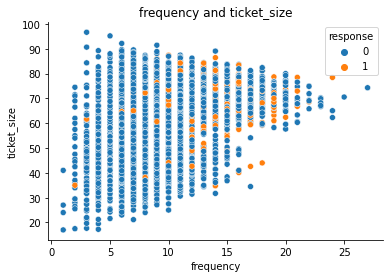

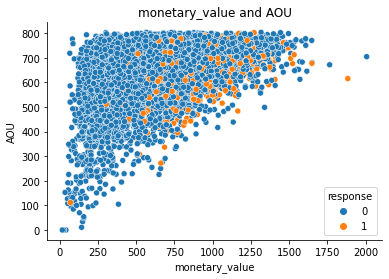

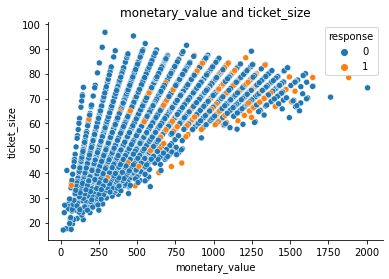

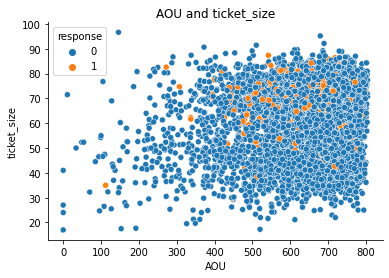

In [21]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [22]:
sm = SMOTE(random_state=0)

# fit_sample -- >> fit_resample
sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [23]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1883
           1       0.70      0.74      0.72      1883

    accuracy                           0.71      3766
   macro avg       0.71      0.71      0.71      3766
weighted avg       0.71      0.71      0.71      3766

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      4354
           1       0.19      0.73      0.30       465

    accuracy                           0.67      4819
   macro avg       0.58      0.70      0.55      4819
weighted avg       0.89      0.67      0.74      4819



In [24]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1883
           1       0.72      0.74      0.73      1883

    accuracy                           0.73      3766
   macro avg       0.73      0.73      0.73      3766
weighted avg       0.73      0.73      0.73      3766

test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      4354
           1       0.20      0.68      0.30       465

    accuracy                           0.70      4819
   macro avg       0.57      0.69      0.56      4819
weighted avg       0.88      0.70      0.76      4819



## **XGBoost**

In [25]:
print('XGBoost model - SMOTE RFM')

## Tune hyperparameter
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate = 0.5,  #0.01
 n_estimators = 100, #100
 max_depth = 10, #2
 gamma = 0.0, #0.0
 colsample_bytree = 0.6) # 0.6
 
predicted_y = []
expected_y = []

# reorder data in dataFrame
X_SMOTE_rfm = X_SMOTE_rfm[["frequency", "monetary_value", "recency"]]
X_test_rfm = X_test_rfm[["frequency", "monetary_value", "recency"]]

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm, y_test_rfm)])

predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.744345
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.737154
[2]	validation_0-auc:0.763806
[3]	validation_0-auc:0.767663
[4]	validation_0-auc:0.752765
[5]	validation_0-auc:0.736839
[6]	validation_0-auc:0.747027
[7]	validation_0-auc:0.751706
[8]	validation_0-auc:0.752891
Stopping. Best iteration:
[3]	validation_0-auc:0.767663

training set
              precision    recall  f1-score   support

           0       0.80      0.72      0.75      1883
           1       0.74      0.82      0.78      1883

    accuracy                           0.77      3766
   macro avg       0.77      0.77      0.77      3766
weighted avg       0.77      0.77      0.77      3766

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      4354
           1       0.20      0.69      0.30       465

    accuracy                           0.69      4819
   macro avg     

In [26]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.5, #0.01
 n_estimators=100, #100
 max_depth=10, #2
 gamma=0.0, #0.0
 colsample_bytree=0.6) #0.6

predicted_y = []
expected_y = []

# reorder data in dataFrame
X_SMOTE_clv = X_SMOTE_clv[["AOU", "ticket_size", "frequency", "monetary_value"]]
X_test_clv_xgb = X_test_clv[["AOU", "ticket_size", "frequency", "monetary_value"]]

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv_xgb, y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv_xgb)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.676952
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.67691
[2]	validation_0-auc:0.679159
[3]	validation_0-auc:0.673272
[4]	validation_0-auc:0.691455
[5]	validation_0-auc:0.697509
[6]	validation_0-auc:0.695518
[7]	validation_0-auc:0.698437
[8]	validation_0-auc:0.694209
[9]	validation_0-auc:0.698176
[10]	validation_0-auc:0.699824
[11]	validation_0-auc:0.700755
[12]	validation_0-auc:0.69818
[13]	validation_0-auc:0.697137
[14]	validation_0-auc:0.69248
[15]	validation_0-auc:0.689989
[16]	validation_0-auc:0.69029
Stopping. Best iteration:
[11]	validation_0-auc:0.700755

training set
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1883
           1       0.92      0.98      0.95      1883

    accuracy                           0.95      3766
   macro avg       0.95      0.95      0.95      3766
weighted avg       0.95      0.95      0.95      3766



In [27]:
# #print(xgb_model)
# #X_SMOTE_rfm = X_SMOTE_rfm[["frequency", "monetary_value", "recency"]]
# #print( X_SMOTE_rfm)
# print( y_SMOTE_rfm)
# X_test_rfm = X_test_rfm[["frequency", "monetary_value", "recency"]]
# print( X_test_rfm)
# print( y_test_rfm)
# print( X_test_rfm.to_numpy())

# reorder data in dataFrame
#X_SMOTE_clv = X_SMOTE_clv[["AOU", "ticket_size", "frequency", "monetary_value"]]
#X_test_clv = X_test_clv[["AOU", "ticket_size", "frequency", "monetary_value"]]

#recency	frequency	monetary_value	AOU	ticket_size


print(X_SMOTE_clv )
print(y_SMOTE_clv )
print(X_test_clv )
print(y_test_clv )

      AOU  ticket_size  frequency  monetary_value
0     722    73.642857         14            1031
1     656    41.625000          8             333
2     639    76.538462         13             995
3     748    64.687500         16            1035
4     590    71.200000          5             356
...   ...          ...        ...             ...
3761  445    69.180449         10             700
3762  759    80.923786         18            1459
3763  720    44.746617         11             495
3764  445    30.448579          7             236
3765  607    65.381632          9             615

[3766 rows x 4 columns]
0       0
1       0
2       0
3       0
4       0
       ..
3761    1
3762    1
3763    1
3764    1
3765    1
Name: response, Length: 3766, dtype: int64
      recency  frequency  monetary_value  AOU  ticket_size
5546     28.0          7             286  675    40.857143
3027    158.0         15            1050  642    70.000000
6234     90.0          7             396  665

In [28]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [29]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range( 2, 5),
    'clf__colsample_bytree': [i/10 for i in range( 4, 5)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits= 5, random_state=50, shuffle=True )
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [30]:
X_test_clv

,recency,frequency,monetary_value,AOU,ticket_size
5546,28.0,7,286,675,40.857143
3027,158.0,15,1050,642,70.000000
6234,90.0,7,396,665,56.571429
4308,19.0,11,675,735,61.363636
3035,25.0,16,1045,755,65.312500
...,...,...,...,...,...
1592,42.0,15,1016,562,67.733333
6657,65.0,5,206,550,41.200000
6628,47.0,6,288,520,48.000000
4253,64.0,12,871,730,72.583333


In [31]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv.to_numpy())
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.773580512161122
Accuracy: 0.6955799958497614
[[3027 1327]
 [ 140  325]]
test set
              precision    recall  f1-score   support

           0       0.96      0.70      0.80      4354
           1       0.20      0.70      0.31       465

    accuracy                           0.70      4819
   macro avg       0.58      0.70      0.56      4819
weighted avg       0.88      0.70      0.76      4819



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  "X does not have valid feature names, but"


In [32]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f696fd973b0>}


Best AUC Score: 0.773580512161122
Accuracy: 0.6955799958497614
[[3027 1327]
 [ 140  325]]
test set
              precision    recall  f1-score   support

           0       0.96      0.70      0.80      4354
           1       0.20      0.70      0.31       465

    accuracy                           0.70      4819
   macro avg       0.58      0.70      0.56      4819
weighted avg       0.88      0.70      0.76      4819